In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import SGD,Adam
from tensorflow.keras.optimizers import RMSprop
from google.colab.patches import cv2_imshow
import numpy as np
import os
import cv2
import time
import itertools

# Model

In [ ]:
from re import X
from keras.engine.training import Model
from keras.api._v2.keras import activations


class Siamese_neural_networks :
    def __init__(self) :
        """
        We initialized all network weights
        in the convolutional layers from a normal distribution with
        zero-mean and a standard deviation of 1e-2

        Biases were also initialized from a normal distribution, 
        but with mean 0.5 and standard deviation 1e-2

        In the fully-connected layers, 
        the biases were initialized in the same way as the convolutional layers, 
        but the weights were drawn from a much wider normal distribution with zero-mean and standard deviation 2e-1
        ==============
        """
        # 가중치값 평균:0, 표준편차 1e-2인 정규분포로 초기화
        self.conv_layer_weight_init = tf.keras.initializers.RandomNormal(mean=0, stddev=0.1)
        # 바이어스 값 평균:0.5, 표준편차:1e-2인 정규분포로 초기화
        self.conv_layer_bias_init = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.01)

        # 가중치값 평균:0, 표준편차 2e-1인 정규분포로 초기화
        self.dense_layer_weight_init = tf.keras.initializers.RandomNormal(mean=0, stddev=0.2)
        # 바이어스 값 평균:0.5, 표준편차:1e-2인 정규분포로 초기화
        self.dense_layer_bias_init = tf.keras.initializers.RandomNormal(mean=0.5, stddev=0.01)

        self.input_shape = (105, 105, 1)
        self.best_weights = None
    
    def create_network(self) :
        """
        3.1. Model:
        The number of convolutional
        filters is specified as a multiple of 16 to optimize performance. 
        ==============
        필터의 성능을 최적화하기 위해 16의 배수로 지정한다.
        --------------
        Hyperparameter optimization:
        layer-wise L2 regularization penalty λj ∈ [0, 0.1]
        ==============
        각 레이어에 L2 정규화 패널티를 적용하였다. 계층별 L2 정규화 패널티 λj는 [0, 0.1] 범위에 있다.

        가중치 제곱에 L2 정규화 항을 곱한다. 이 값을 모델의 손실함수 binary_crossentropy의 값에 더함으로써
        손실함수는 binary_crossentropy의 값 뿐만 아니라 가중치 제곱항의 값 또한 고려하게 된다.
        가중치의 값이 클수록 손실함수의 값이 커지므로 신경망은 가중치가 작도록 노력할 것이다.
        이를 통해 가중치가 과도하게 커져 발생하는 과대적합을 방지할 수 있다.

        L2 정규화 항의 가중치인 '2e-4', '1e-3'는 타 자료를 참고하여, 
        다른 분들이 이미 논문에 나온 Bayesian optimization framework Whetlab을 통해 구한듯한 값을 사용한 것이다.
        """                                
        convolutional_network = Sequential()
        convolutional_network.add(Conv2D(filters=64, 
                                        kernel_size=(10, 10),
                                        activation='relu',
                                        input_shape=self.input_shape,
                                        # L2 정규화 패널티를 적용
                                        kernel_regularizer = tf.keras.regularizers.L2(2e-4),
                                        # 가중치값 평균:0, 표준편차 1e-2인 정규분포로 초기화
                                        kernel_initializer=self.conv_layer_weight_init,
                                        # 바이어스 값 평균:0.5, 표준편차:1e-2인 정규분포로 초기화
                                        bias_initializer=self.conv_layer_bias_init,
                                        name='Conv_1'))
        
        convolutional_network.add(MaxPooling2D(pool_size=(2,2), name='Maxpooling_1'))

        convolutional_network.add(Conv2D(filters=128, 
                                        kernel_size=(7, 7),
                                        activation='relu',
                                        # L2 정규화 패널티를 적용
                                        kernel_regularizer = tf.keras.regularizers.L2(2e-4),
                                        # 가중치값 평균:0, 표준편차 1e-2인 정규분포로 초기화
                                        kernel_initializer=self.conv_layer_weight_init,
                                        # 바이어스 값 평균:0.5, 표준편차:1e-2인 정규분포로 초기화
                                        bias_initializer=self.conv_layer_bias_init,
                                        name='Conv_2'))
        
        convolutional_network.add(MaxPooling2D(pool_size=(2,2), name='Maxpooling_2'))

        convolutional_network.add(Conv2D(filters=128, 
                                        kernel_size=(4, 4),
                                        activation='relu',
                                        # L2 정규화 패널티를 적용
                                        kernel_regularizer = tf.keras.regularizers.L2(2e-4),
                                        # 가중치값 평균:0, 표준편차 1e-2인 정규분포로 초기화
                                        kernel_initializer=self.conv_layer_weight_init,
                                        # 바이어스 값 평균:0.5, 표준편차:1e-2인 정규분포로 초기화
                                        bias_initializer=self.conv_layer_bias_init,
                                        name='Conv_3'))
        
        convolutional_network.add(MaxPooling2D(pool_size=(2,2), name='Maxpooling_3'))

        convolutional_network.add(Conv2D(filters=256, 
                                        kernel_size=(4, 4),
                                        activation='relu',
                                        # L2 정규화 패널티를 적용
                                        kernel_regularizer = tf.keras.regularizers.L2(2e-4),
                                        # 가중치값 평균:0, 표준편차 1e-2인 정규분포로 초기화
                                        kernel_initializer=self.conv_layer_weight_init,
                                        # 바이어스 값 평균:0.5, 표준편차:1e-2인 정규분포로 초기화
                                        bias_initializer=self.conv_layer_bias_init,
                                        name='Conv_4'))
        
        convolutional_network.add(Flatten())


        convolutional_network.add(Dense(units=4096,
                                        activation='sigmoid',
                                        # L2 정규화 패널티를 적용
                                        kernel_regularizer = tf.keras.regularizers.L2(1e-3),
                                        # 가중치값 평균:0, 표준편차 2e-1인 정규분포로 초기화
                                        kernel_initializer=self.dense_layer_weight_init,
                                        # 바이어스 값 평균:0.5, 표준편차:1e-2인 정규분포로 초기화
                                        bias_initializer=self.dense_layer_bias_init,
                                        name='Dense_1'))
        
        input_a = Input(self.input_shape, name='input_a')
        input_b = Input(self.input_shape, name='input_b')

        encoded_image_1 = convolutional_network(input_a)
        encoded_image_2 = convolutional_network(input_b)

        L1_layer = Lambda(lambda tensors:tf.abs(tensors[0] - tensors[1]))
        L1_distance = L1_layer([encoded_image_1, encoded_image_2])

        output_layer = Dense(units=1,
                             activation='sigmoid',
                             name='output_layer')(L1_distance)

        self.model = Model(inputs=[input_a, input_b], outputs=output_layer)
        """
        Optimization:
        We fix a minibatch size of 128 with learning rate ηj , 
        momentum µj , and L2 regularization weights λj defined layer-wise
        ==============
        우리는 미니배치 크기를 128로 고정하고, 학습률 ηj, 모멘텀 µj, 그리고 L2 정규화 가중치 λj를 계층별로 정의한다.

        논문에 나온 Optimizer의 형태와 가장 비슷한 SDG를 사용한다.
        --------------
        Hyperparameter optimization :
        we set the layerwise learning rate ηj ∈ [1e-4, 1e-1], 
        layer-wise momentum µj ∈ [0, 1]
        ==============
        모멘텀은 모든 계층에서 0.5에서 시작하여, 
        각 에포크마다 선형적으로 증가하여 j번째 계층에 대한 개별 모멘텀 항 µj 값을 도달하게 했다.

        논문을 구현한 다른 코드를 참고하며, learning_rate는 1e-1, momentum은 5e-1로 설정한다.
        --------------
        Loss function :
        We impose a regularized cross-entropy objective on our binary classifier of the following form:
        ==============
        loss 함수로 binary_crossentropy를 사용한다
        """
        optimizer = tf.keras.optimizers.experimental.SGD(learning_rate=0.1, momentum=0.5)

        self.model.compile(loss = 'binary_crossentropy', metrics=['binary_accuracy'], optimizer=optimizer)

        return self.model
    
    def train_model(self, siamese_model, data) :
        self.x_ONE_train, self.x_TWO_train, self.y_train = data
        with tf.GradientTape() as tape :
            self.y_pred = siamese_model([self.x_ONE_train, self.x_TWO_train], training=True)
            self.y_pred = tf.squeeze(self.y_pred, axis=-1) 

            loss_fn = tf.keras.losses.BinaryCrossentropy()
            acc_fn = tf.keras.metrics.BinaryAccuracy()

            loss = loss_fn(self.y_train, self.y_pred)
            acc = acc_fn(self.y_train, self.y_pred)
        gradients = tape.gradient(loss, siamese_model.trainable_weights)
        siamese_model.optimizer.apply_gradients(zip(gradients, siamese_model.trainable_weights))
    
        return {"loss": loss, "accuracy": acc}

# Create dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import natsort
start = time.time()
path = "/content/drive/MyDrive/A.아이/images/ATandT/"
dataset_listdir = natsort.natsorted(os.listdir(path))
print("time :", time.time() - start)

time : 1.635862112045288


In [ ]:
start = time.time()
img_list, img_label = [], []
for folder_name in dataset_listdir :
    image_name_list = natsort.natsorted(os.listdir(path+folder_name))
    for image_name in image_name_list :
        img = cv2.imread(path+folder_name+'/'+image_name)
        resized_image = cv2.resize(img, (105, 105))
        face_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
        img_list.append(face_image)
        img_label.append(folder_name)
print("time :", time.time() - start)
len(img_list), len(img_label)

time : 328.31473112106323


(400, 400)

In [ ]:
def generate_train_image_pairs(images_dataset, labels_dataset):
    unique_labels = np.unique(labels_dataset)
    label_wise_indices = dict()
    for label in unique_labels:
        label_wise_indices.setdefault(label,
                                      [index for index, curr_label in enumerate(labels_dataset) if
                                       label == curr_label])
    
    pair_images = []
    pair_labels = []
    for index, image in enumerate(images_dataset):
        pos_indices = label_wise_indices.get(labels_dataset[index])
        pos_image = images_dataset[np.random.choice(pos_indices)]
        pair_images.append((image, pos_image))
        pair_labels.append(1)

        neg_indices = np.where(labels_dataset != labels_dataset[index])
        neg_image = images_dataset[np.random.choice(neg_indices[0])]
        pair_images.append((image, neg_image))
        pair_labels.append(0)
    return np.array(pair_images), np.array(pair_labels)

In [ ]:
img_list_np = np.array(img_list)
train_image_np = img_list_np[:300]

img_label_np = np.array(img_label)
train_label_np = img_label_np[:300]

In [ ]:
# create train image list
x_train_pairs, y_train_pairs = generate_train_image_pairs(train_image_np, train_label_np)
x_train_pairs.shape ,y_train_pairs.shape

((600, 2, 105, 105), (600,))

In [ ]:
unique, counts = np.unique(np.reshape(y_train_pairs, (x_train_pairs.shape[0],)), return_counts=True)
dict(zip(unique, counts))

{0: 300, 1: 300}

In [ ]:
img_list_np = np.array(img_list)
test_image_np = img_list_np[300:]

img_label_np = np.array(img_label)
test_label_np = img_label_np[300:]

In [ ]:
# create test image list
x_test_pairs, y_test_pairs = generate_train_image_pairs(test_image_np, test_label_np)
x_test_pairs.shape ,y_test_pairs.shape

((200, 2, 105, 105), (200,))

In [ ]:
unique, counts = np.unique(np.reshape(y_test_pairs, (x_test_pairs.shape[0],)), return_counts=True)
dict(zip(unique, counts))

{0: 100, 1: 100}

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_pairs, y_train_pairs))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(128)

val_dataset = tf.data.Dataset.from_tensor_slices((x_test_pairs, y_test_pairs))
val_dataset = val_dataset.batch(128)

# Training

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


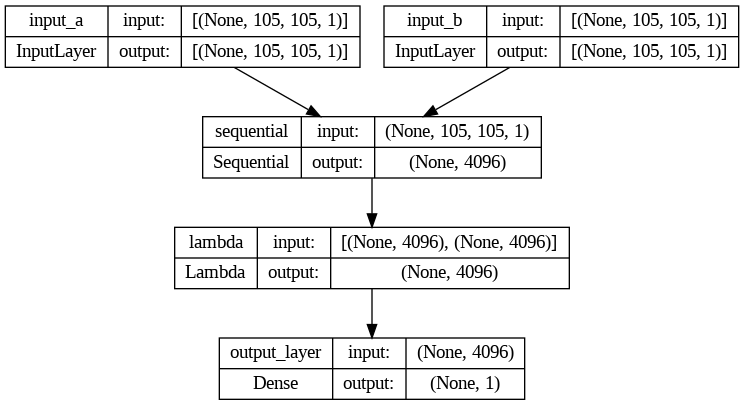

In [ ]:
create_Siamese_network_model = Siamese_neural_networks()
model = create_Siamese_network_model.create_network()
plot_model(model, show_shapes=True)

In [ ]:
best_val_loss = float("inf")
count = 0
for epoch in range(200):
    print("\nStart of epoch %d" % (epoch,))
    # Iterate over the pairs of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        x1_batch_train = x_batch_train[:, 0]
        x2_batch_train = x_batch_train[:, 1]

        logs = create_Siamese_network_model.train_model(model, data=(x1_batch_train, x2_batch_train, y_batch_train))

        if step % 200 == 0:
            print("Training loss (for one batch) at step %d: %.4f"% (step, float(logs["loss"])))
            print("Seen so far: %d samples, accuracy: %.4f"% ((step + 1) * 128, float(logs["accuracy"])))
    
    val_loss = 0
    val_acc = 0
    for x_batch_val, y_batch_val in val_dataset:
        x1_batch_val = x_batch_val[:, 0]
        x2_batch_val = x_batch_val[:, 1]

        val_pred = create_Siamese_network_model.train_model(model, data=(x1_batch_val, x2_batch_val, y_batch_val))
        val_loss += val_pred["loss"]
        val_acc += val_pred["accuracy"]
    
    val_loss /= len(val_dataset)
    val_acc /= len(val_dataset)
    print("Validation loss: %.4f" % (float(val_loss),))
    print("Validation accuracy: %.4f" % (float(val_acc),))

    # Decay learning rate
    lr = float(model.optimizer.learning_rate)
    # Increase momentum
    momentum = min(float(model.optimizer.momentum) + 0.01, 0.9)
    optimizer = tf.keras.optimizers.SGD(learning_rate=lr*0.99, momentum=momentum, nesterov=True)
    model.optimizer = optimizer

    # Check early stopping condition
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        count = 0
        create_Siamese_network_model.best_weights = model.get_weights()  # Save the best weights
    else:
        count += 1
        if count >= 20:
            print("Early stopping")
            break

In [ ]:
model.set_weights(create_Siamese_network_model.best_weights)
model.save('/content/drive/MyDrive/A.아이/github/models_folder/model_siamese_neural_network.h5')

# Test

## friends dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install mediapipe

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.9/33.9 MB 58.0 MB/s eta 0:00:00


In [ ]:
friends_path_first = '/content/drive/MyDrive/A.아이/images/friends_image/fist_image/'
friends_path_first_name = os.listdir(friends_path_first)

friends_path_second = '/content/drive/MyDrive/A.아이/images/friends_image/second_image/'
friends_path_second_name = os.listdir(friends_path_second)

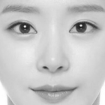

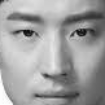

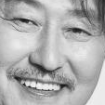

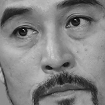

In [ ]:
import mediapipe as mp

mp_face_detection = mp.solutions.face_detection
image_friends_first_list = []
margin = 0.15  # Adjust this value to change the cropping margin

for name in friends_path_first_name :
    img = cv2.imread(friends_path_first + name)
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
            face = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if face.detections:
                for i, detection in enumerate(face.detections):
                    # Get bounding box coordinates
                    box = detection.location_data.relative_bounding_box
                    ih, iw, _ = img.shape
                    x, y, w, h = int(box.xmin * iw), int(box.ymin * ih), int(box.width * iw), int(box.height * ih)
                    
                    # Calculate margins for x, y, w, h
                    mx = int(w * margin)
                    my = int(h * margin)
                    
                    # Crop the face with margins
                    face_image = img[y+my:y+h-my, x+mx:x+w-mx]
                    if face_image.size != 0:
                        # Resize the image to 105x105
                        face_image = cv2.resize(face_image, (105, 105))
                        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
                    else :
                        break
            else :
                print('cant find face')
                continue
    image_friends_first_list.append(face_image)

for i in image_friends_first_list :
    cv2_imshow(i)


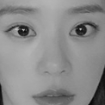

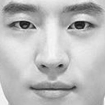

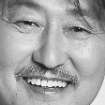

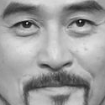

In [ ]:
mp_face_detection = mp.solutions.face_detection
image_friends_second_list = []
margin = 0.15  # Adjust this value to change the cropping margin

for name in friends_path_second_name :
    img = cv2.imread(friends_path_second + name)
    with mp_face_detection.FaceDetection(model_selection=1, min_detection_confidence=0.5) as face_detection:
            face = face_detection.process(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            if face.detections:
                for i, detection in enumerate(face.detections):
                    # Get bounding box coordinates
                    box = detection.location_data.relative_bounding_box
                    ih, iw, _ = img.shape
                    x, y, w, h = int(box.xmin * iw), int(box.ymin * ih), int(box.width * iw), int(box.height * ih)
                    
                    # Calculate margins for x, y, w, h
                    mx = int(w * margin)
                    my = int(h * margin)
                    
                    # Crop the face with margins
                    face_image = img[y+my:y+h-my, x+mx:x+w-mx]
                    if face_image.size != 0:
                        # Resize the image to 105x105
                        face_image = cv2.resize(face_image, (105, 105))
                        face_image = cv2.cvtColor(face_image, cv2.COLOR_BGR2GRAY)
                    else :
                        break
            else :
                print('cant find face')
                continue
    image_friends_second_list.append(face_image)

for i in image_friends_second_list :
    cv2_imshow(i)


In [ ]:
image_friends_first_list = np.array(image_friends_first_list)
image_friends_second_list = np.array(image_friends_second_list)

image_friends_first_list.shape, image_friends_second_list.shape

((4, 105, 105), (4, 105, 105))

## test_model with friends


In [ ]:
from tensorflow.keras.models import load_model
test_model = load_model('/content/drive/MyDrive/A.아이/github/models_folder/model_siamese_neural_network.h5')

/usr/local/lib/python3.10/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [ ]:
def test_model_with_friends(index, image_friends_first_list, image_friends_second_list) : 
    # Your anchor image, let's use the first image from the test set as an example
    anchor_image = image_friends_first_list[index]  # Taking the first image from the first pair as an anchor image
    anchor_image = np.expand_dims(anchor_image, axis=0)  # Add batch dimension
    print(anchor_image.shape)

    # Variables to keep track of most similar images
    most_similar_images = []  # A list to keep track of the indices of the most similar images
    highest_similarities = []  # A list to keep track of the highest similarities

    # Images list from your data
    images_list = image_friends_second_list  # All second images from the test pairs

    # Iterate over images
    for i, image in enumerate(images_list):
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        # Predict the similarity
        similarity = test_model.predict([anchor_image, image])[0][0]

        # If this image is more similar than the least similar image in most_similar_images, update most_similar_images
        if len(highest_similarities) < 5 or similarity > min(highest_similarities):
            if len(highest_similarities) == 5:
                # Remove the least similar image if we already have 5 images
                min_index = highest_similarities.index(min(highest_similarities))
                highest_similarities.pop(min_index)
                most_similar_images.pop(min_index)

            # Add new image
            highest_similarities.append(similarity)
            most_similar_images.append(i)  # Keeping track of the index rather than image
    # Show the most similar image index
    cv2_imshow(image_friends_first_list[index])
    cv2_imshow(image_friends_second_list[most_similar_images[0]])
    print('The similarity score is:', highest_similarities[0])
    cv2_imshow(image_friends_second_list[most_similar_images[1]])
    print('The similarity score is:', highest_similarities[1])
    cv2_imshow(image_friends_second_list[most_similar_images[2]])
    print('The similarity score is:', highest_similarities[2])
    cv2_imshow(image_friends_second_list[most_similar_images[3]])
    print('The similarity score is:', highest_similarities[3])
    cv2_imshow(image_friends_second_list[most_similar_images[4]])
    print('The similarity score is:', highest_similarities[4])

(1, 105, 105)
1/1 [==============================] - 0s 18ms/step


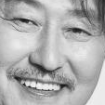

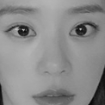

The similarity score is: 0.0046046325


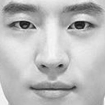

The similarity score is: 0.013153449


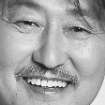

The similarity score is: 0.98135734


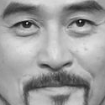

The similarity score is: 0.03626531


IndexError: ignored

In [ ]:
test_model_with_friends(2, image_friends_first_list, image_friends_second_list)

## test model with testdata

In [ ]:
# Your anchor image, let's use the first image from the test set as an example
anchor_image = x_test_pairs[index, 0, :, :]  # Taking the first image from the first pair as an anchor image
anchor_image = np.expand_dims(anchor_image, axis=0)  # Add batch dimension
print(anchor_image.shape)

# Variables to keep track of most similar images
most_similar_images = []  # A list to keep track of the indices of the most similar images
highest_similarities = []  # A list to keep track of the highest similarities

# Images list from your data
images_list = x_test_pairs[:, 1, :, :]  # All second images from the test pairs

# Iterate over images
for i, image in enumerate(images_list):
    image = np.expand_dims(image, axis=0)  # Add batch dimension
    # Predict the similarity
    similarity = test_model.predict([anchor_image, image])[0][0]

    # If this image is more similar than the least similar image in most_similar_images, update most_similar_images
    if len(highest_similarities) < 5 or similarity > min(highest_similarities):
        if len(highest_similarities) == 5:
            # Remove the least similar image if we already have 5 images
            min_index = highest_similarities.index(min(highest_similarities))
            highest_similarities.pop(min_index)
            most_similar_images.pop(min_index)

        # Add new image
        highest_similarities.append(similarity)
        most_similar_images.append(i)  # Keeping track of the index rather than image
# Show the most similar image index
cv2_imshow(x_test_pairs[index, 0, :, :])
cv2_imshow(x_test_pairs[most_similar_images[0], 1, :, :])
print('The similarity score is:', highest_similarities[0])
cv2_imshow(x_test_pairs[most_similar_images[1], 1, :, :])
print('The similarity score is:', highest_similarities[1])
cv2_imshow(x_test_pairs[most_similar_images[2], 1, :, :])
print('The similarity score is:', highest_similarities[2])
cv2_imshow(x_test_pairs[most_similar_images[3], 1, :, :])
print('The similarity score is:', highest_similarities[3])
cv2_imshow(x_test_pairs[most_similar_images[4], 1, :, :])
print('The similarity score is:', highest_similarities[4])